In [275]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import argparse
import ast
import sys
import gzip
import csv
import pprint
import pandas as pd
import neet.sensitivity as ns
import neet.boolean as nn
from neet.boolean.examples import c_elegans

from scipy import stats
import scipy as sp
import community
from scipy.spatial.distance import pdist, squareform
from sklearn import datasets
from matplotlib import patches

from network_ei import *
from get_motifs import *

import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

%matplotlib inline

In [2]:
def draw_adjacency_matrix(G, node_order=None, partitions=[], colors=[]):
    """
    - G is a netorkx graph
    - node_order (optional) is a list of nodes, where each node in G
          appears exactly once
    - partitions is a list of node lists, where each node in G appears
          in exactly one node list
    - colors is a list of strings indicating what color each
          partition should be
    If partitions is specified, the same number of colors needs to be
    specified.
    """
    adjacency_matrix = nx.to_numpy_matrix(G, dtype=np.bool, nodelist=node_order)
    N = G.number_of_nodes()

    fig = plt.figure(figsize=(12, 12)) # in inches
    plt.imshow(adjacency_matrix, cmap="Greys", interpolation="none")

    plt.xticks(np.arange(0, N, 1), []);
    plt.yticks(np.arange(0, N, 1), []);
    plt.xticks(np.arange(-.5, N-.5, 1), []);
    plt.yticks(np.arange(-.5, N-.5, 1), []);
    plt.grid(color='darkgrey', linestyle='-', linewidth=0.5)
    
    assert len(partitions) == len(colors)
    ax = plt.gca()
    for partition, color in zip(partitions, colors):
        current_idx = 0
        for module in partition:
            ax.add_patch(patches.Rectangle((current_idx, current_idx),
                                          len(module), # Width
                                          len(module), # Height
                                          facecolor="none",
                                          edgecolor=color,
                                          linewidth=3, alpha=0.8))
            current_idx += len(module)
            
def assignmentArray_to_lists(assignment_array):
    by_attribute_value = defaultdict(list)
    for node_index, attribute_value in enumerate(assignment_array.values()):
        by_attribute_value[attribute_value].append(node_index)
    return by_attribute_value.values()

In [3]:
colors = ["#91b43f","#7463cd","#54bc5b","#c560c7","#49925d","#cf4085","#49bfba","#cf4d2b","#6f8bce","#dd862f","#98558b",
"#c7a745","#dd85a8", "#777d35","#c64855","#9b5e2f","#e0906e"]

In [6]:
header_mapping = dict(zip(colHeaders, ['NetworkID', 'N', 'URL_paper', 'URL_data', 
                      'PaperCitation', 'PaperJournal', 'PaperTitle', 'PaperYear',
                      'System', 'InteractionsFromLit', 'InferredInteractionsFromLit', 
                      'InferredInteractionsFromExp', 'ExpPerformedForPape']))

In [7]:
# get metadata

with open('data/network-metadata.csv', mode='r', errors='ignore') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    line_count = 0
    out_dict = {}
    for row in csv_reader:
        if line_count == 0:
            colHeaders = list(row)
            for i in colHeaders:
                out_dict[header_mapping[i]] = []
            line_count += 1
        else:
            count = 0
            vals = list(row.values())
            for i in out_dict.keys():
                if i=='N' or i=='PaperYear':
                    out_dict[i].append(int(vals[count]))
                else:
                    out_dict[i].append(vals[count])
                count += 1
            line_count += 1

In [463]:
out_dict['URL_data']

['https://cellcollective.org/#2681/cell-cycle-transcription-by-coupled-cdk-and-network-oscillators',
 'https://cellcollective.org/#2668/toll-pathway-of-drosophila-signaling-pathway',
 'https://cellcollective.org/#5731/metabolic-interactions-in-the-gut-microbiome',
 'https://cellcollective.org/#5128/lac-operon',
 'https://cellcollective.org/#6885:1/regulation-of-the-larabinose-operon-of-escherichia-coli/1',
 'https://cellcollective.org/#4837:1/arabidopsis-thaliana-cell-cycle/1',
 'https://cellcollective.org/#2136/cardiac-development',
 'https://cellcollective.org/#4790:1/fanconi-anemia-and-checkpoint-recovery/1',
 'https://cellcollective.org/#4706/predicting-variabilities-in-cardiac-gene',
 'https://cellcollective.org/#2699/bt474-breast-cell-line-shortterm-erbb-network',
 'https://cellcollective.org/#2700:1/hcc1954-breast-cell-line-shortterm-erbb-network/1',
 'https://cellcollective.org/#2202:1/neurotransmitter-signaling-pathway/1',
 'https://cellcollective.org/#2701:1/skbr3-breast-cell

In [8]:
# put the graph objects here
network_names = out_dict['NetworkID']
file_names = ["data/walker/gml/"+i.replace(" ", "")+'.gml' for i in network_names]

out_dict['G'] = []
out_dict['EI'] = []
out_dict['eff'] = []
out_dict['determinism'] = []
out_dict['degeneracy'] = []
out_dict['coef_determinism'] = []
out_dict['coef_degeneracy'] = []
out_dict['sensitivity'] = []
out_dict['fn'] = file_names

for fn in out_dict['fn']:
    G = nx.read_gml(fn)
    print(fn)
    N = G.number_of_nodes()
    out_dict['G'].append(G)
    out_dict['EI'].append(get_ei(G))
    out_dict['determinism'].append(get_determinism(G))
    out_dict['degeneracy'].append(get_degeneracy(G))
    out_dict['eff'].append(get_ei(G)/np.log2(N))
    out_dict['coef_determinism'].append(get_determinism(G)/np.log2(N))
    out_dict['coef_degeneracy'].append(get_degeneracy(G)/np.log2(N))
    
#     W_out_test = get_Wout_full(G, p0=0)
#     net = nn.WTNetwork(W_out_test)
#     sens = ns.average_sensitivity(net)
#     out_dict['sensitivity'].append(sens)

data/walker/CellCycleTranscriptionByCoupledCDKAndNetworkOscillators.gml
data/walker/TollPathwayOfDrosophilaSignalingPathway.gml
data/walker/MetabolicInteractionsInTheGutMicrobiome.gml
data/walker/LacOperon.gml
data/walker/RegulationoftheL-arabinoseoperonofEscherichiacoli..gml
data/walker/ArabidopsisthalianaCellCycle.gml
data/walker/CardiacDevelopment.gml
data/walker/FanconiAnemiaAndCheckpointRecovery.gml
data/walker/PredictingVariabilitiesInCardiacGene.gml
data/walker/BT474BreastCellLineShort-termErbBNetwork.gml
data/walker/HCC1954BreastCellLineShort-termErbBNetwork.gml
data/walker/NeurotransmitterSignalingPathway.gml
data/walker/SKBR3BreastCellLineShort-termErbBNetwork.gml
data/walker/BodySegmentationInDrosophila2013.gml
data/walker/BuddingYeastCellCycle2009.gml
data/walker/CD4+TCellDifferentiationAndPlasticity.gml
data/walker/T-LGLSurvivalNetwork2011ReducedNetwork.gml
data/walker/VegfPathwayOfDrosophilaSignalingPathway.gml
data/walker/HumanGonadalSexDetermination.gml
data/walker/Oxid

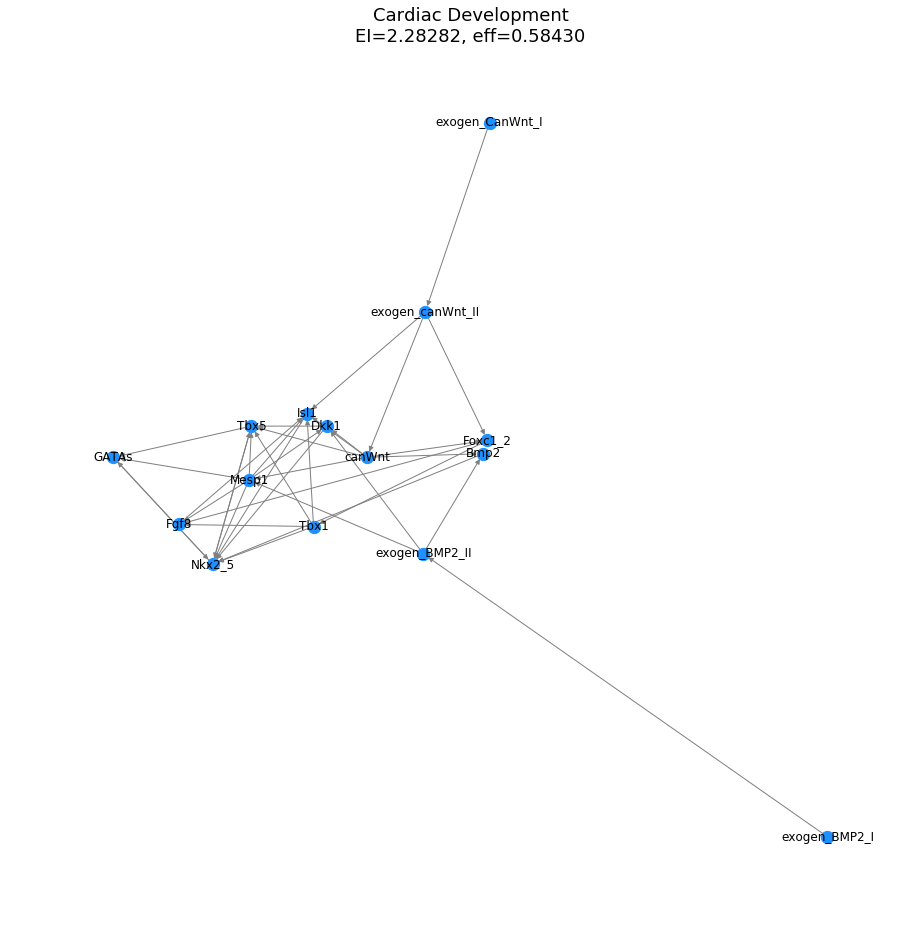

In [9]:
net_id = np.random.choice(list(range(len(out_dict['G']))))
plt.figure(figsize=(12,12))
pos = nx.kamada_kawai_layout(out_dict['G'][net_id])
nx.draw(out_dict['G'][net_id], pos=pos, node_size=150, node_color='dodgerblue', edge_width=1.5, edge_color='grey')
nx.draw_networkx_labels(out_dict['G'][net_id], pos=pos)
plt.title(out_dict['NetworkID'][net_id] + 
          "\nEI=%.5f, eff=%.5f" %(out_dict['EI'][net_id], out_dict['eff'][net_id]), size=18)
plt.show()

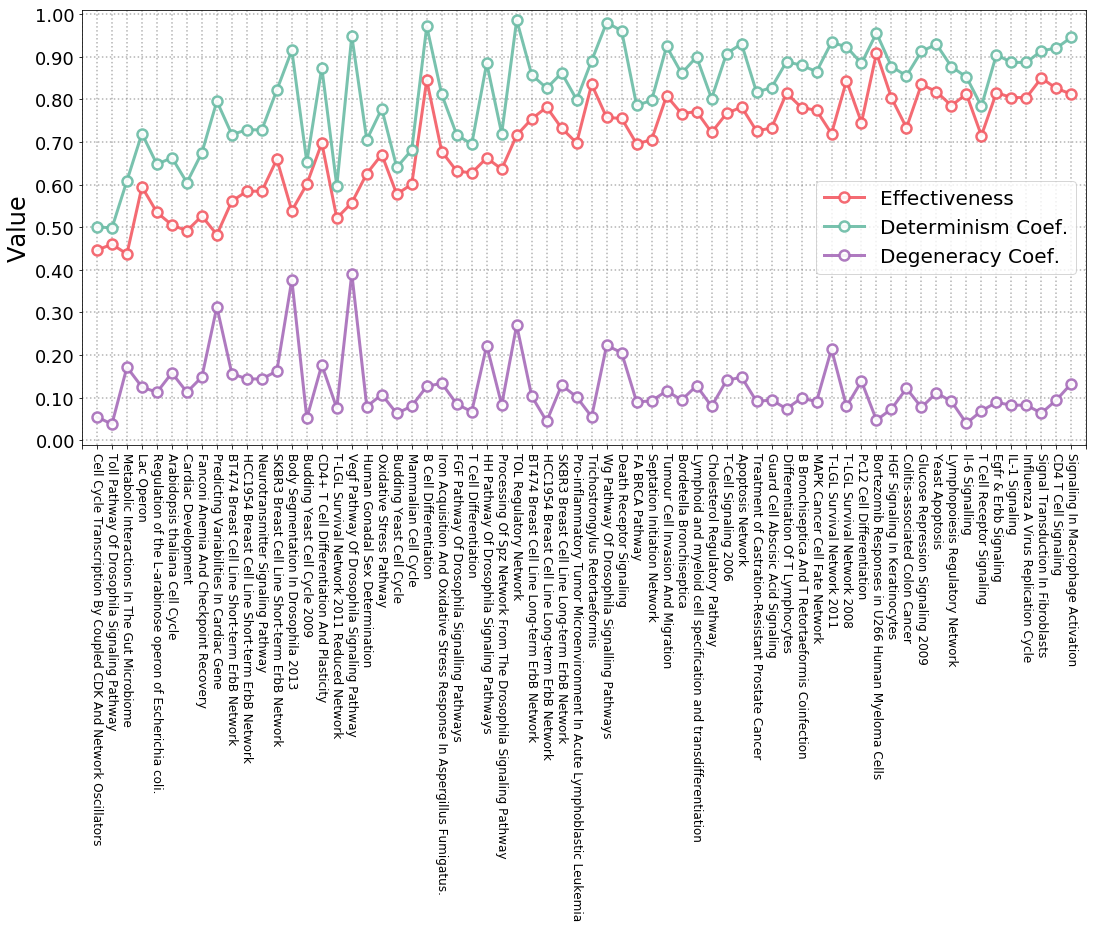

In [169]:
# id_order = np.argsort(out_dict['eff'])
plt.figure(figsize=(18,8))

plt.plot(np.array(out_dict['eff'])[id_order],  marker='o', markersize=10, alpha=0.9,
         linestyle='-', linewidth=3.0,
         markeredgecolor='#f35b64', color='#f35b64', markeredgewidth=2.5, 
         markerfacecolor="w", label='Effectiveness')

plt.plot(np.array(out_dict['coef_determinism'])[id_order], marker='o', markersize=10, alpha=0.9, 
         linestyle='-', linewidth=3.0,
         markeredgecolor='#6abca5', color='#6abca5', markeredgewidth=2.5, 
         markerfacecolor="w", label='Determinism Coef.')

plt.plot(np.array(out_dict['coef_degeneracy'])[id_order],  marker='o', markersize=10, alpha=0.9, 
         linestyle='-', linewidth=3.0, 
         markeredgecolor='#a66cb9', color='#a66cb9', markeredgewidth=2.5, 
         markerfacecolor="w", label='Degeneracy Coef.')

xtix = np.linspace(-1,len(out_dict['NetworkID']),len(out_dict['NetworkID'])+2)
xticklist = [""]
for i in range(len(out_dict['NetworkID'])):
    xticklist.append(out_dict['NetworkID'][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=12)
plt.yticks(np.linspace(0,1,11), ["%.2f"%i for i in np.linspace(0,1,11)], size=18)
plt.grid(alpha=0.6, color='grey', linestyle=':', linewidth=1.5)
plt.xlim(-1,len(out_dict['NetworkID']))
plt.ylim(-0.01,1.01)
plt.ylabel('Value', size=24)
plt.legend(fontsize=20)

# plt.savefig("figs/pngs/Walker_66networks_eff.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/Walker_66networks_eff.pdf", dpi=425, bbox_inches='tight')
plt.show()

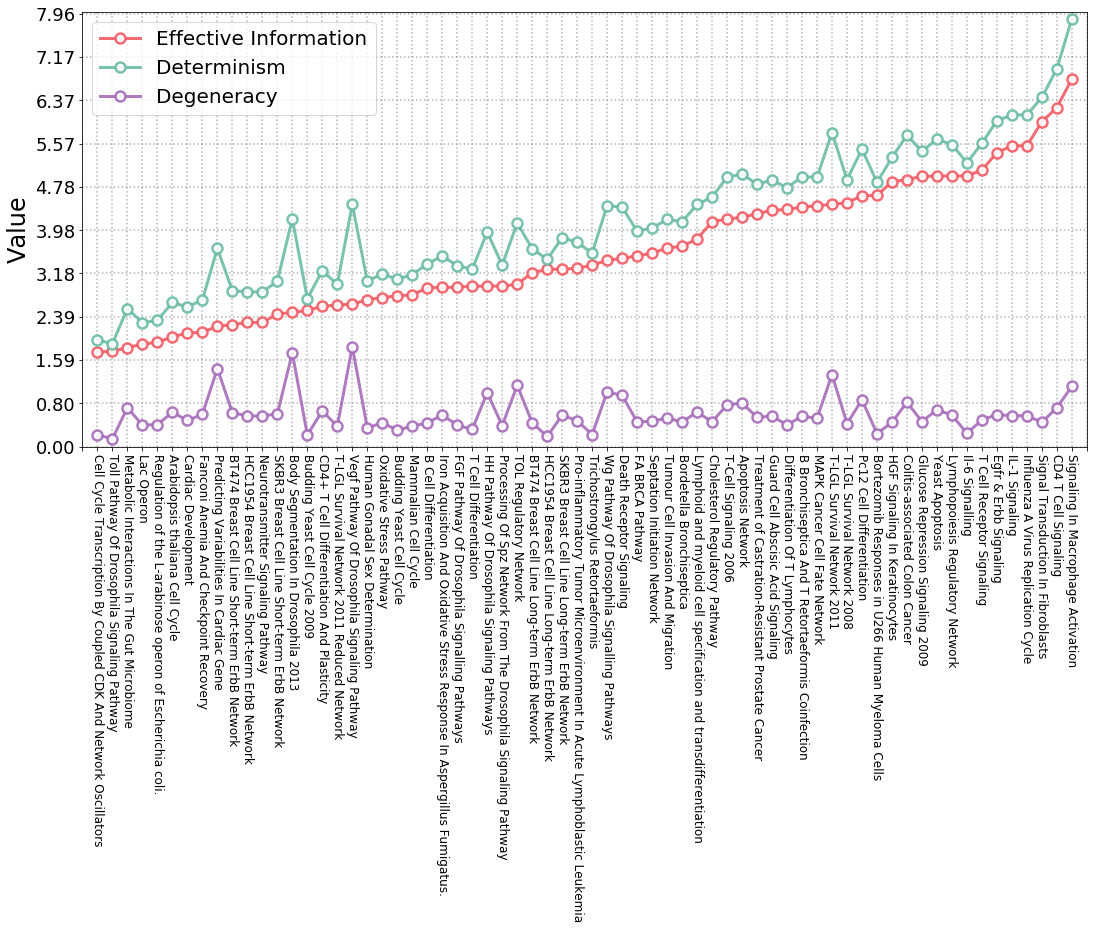

In [168]:
id_order = np.argsort(out_dict['EI'])
plt.figure(figsize=(18,8))

plt.plot(np.array(out_dict['EI'])[id_order],  marker='o', markersize=10, alpha=0.9,
         linestyle='-', linewidth=3.0,
         markeredgecolor='#f35b64', color='#f35b64', markeredgewidth=2.5, 
         markerfacecolor="w", label='Effective Information')

plt.plot(np.array(out_dict['determinism'])[id_order], marker='o', markersize=10, alpha=0.9, 
         linestyle='-', linewidth=3.0,
         markeredgecolor='#6abca5', color='#6abca5', markeredgewidth=2.5, 
         markerfacecolor="w", label='Determinism')

plt.plot(np.array(out_dict['degeneracy'])[id_order],  marker='o', markersize=10, alpha=0.9, 
         linestyle='-', linewidth=3.0, 
         markeredgecolor='#a66cb9', color='#a66cb9', markeredgewidth=2.5, 
         markerfacecolor="w", label='Degeneracy')

xtix = np.linspace(-1,len(out_dict['NetworkID']),len(out_dict['NetworkID'])+2)
xticklist = [""]
for i in range(len(out_dict['NetworkID'])):
    xticklist.append(out_dict['NetworkID'][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=12)
ytix = np.linspace(0,max(out_dict['EI'])+1.2,11)
plt.yticks(ytix, ["%.2f"%i for i in ytix], size=18)
plt.grid(alpha=0.6, color='grey', linestyle=':', linewidth=1.5)
plt.xlim(-1,len(out_dict['NetworkID']))
plt.ylim(0,8.0)
plt.ylabel('Value', size=24)
plt.legend(fontsize=20)

# plt.savefig("figs/pngs/Walker_66networks_EI.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/Walker_66networks_EI.pdf", dpi=425, bbox_inches='tight')
plt.show()

In [76]:
out_dict['sensitivity'] = []
extras = [1.0, 0.9, 0.91, 0.87, 1.18, 0.95]
count = 0
for fn in out_dict['fn']:
    G = nx.read_gml(fn)
    print(fn)
    if  fn!='data/walker/T-LGLSurvivalNetwork2011.gml' and \
        fn!='data/walker/T-LGLSurvivalNetwork2008.gml' and \
        fn!='data/walker/Pc12CellDifferentiation.gml' and \
        fn!='data/walker/InfluenzaAVirusReplicationCycle.gml' and \
        fn!='data/walker/SignalTransductionInFibroblasts.gml' and \
        fn!='data/walker/SignalingInMacrophageActivation.gml':
        W_out_test = nx.to_numpy_array(G)
#         W_out_test = get_Wout_full(G, p0=0)
        net = nn.WTNetwork(W_out_test)
        sens = ns.average_sensitivity(net)
        out_dict['sensitivity'].append(sens)
    else:
        out_dict['sensitivity'].append(extras[count])
        count += 1

data/walker/CellCycleTranscriptionByCoupledCDKAndNetworkOscillators.gml
data/walker/TollPathwayOfDrosophilaSignalingPathway.gml
data/walker/MetabolicInteractionsInTheGutMicrobiome.gml
data/walker/LacOperon.gml
data/walker/RegulationoftheL-arabinoseoperonofEscherichiacoli..gml
data/walker/ArabidopsisthalianaCellCycle.gml
data/walker/CardiacDevelopment.gml
data/walker/FanconiAnemiaAndCheckpointRecovery.gml
data/walker/PredictingVariabilitiesInCardiacGene.gml
data/walker/BT474BreastCellLineShort-termErbBNetwork.gml
data/walker/HCC1954BreastCellLineShort-termErbBNetwork.gml
data/walker/NeurotransmitterSignalingPathway.gml
data/walker/SKBR3BreastCellLineShort-termErbBNetwork.gml
data/walker/BodySegmentationInDrosophila2013.gml
data/walker/BuddingYeastCellCycle2009.gml
data/walker/CD4+TCellDifferentiationAndPlasticity.gml
data/walker/T-LGLSurvivalNetwork2011ReducedNetwork.gml
data/walker/VegfPathwayOfDrosophilaSignalingPathway.gml
data/walker/HumanGonadalSexDetermination.gml
data/walker/Oxid

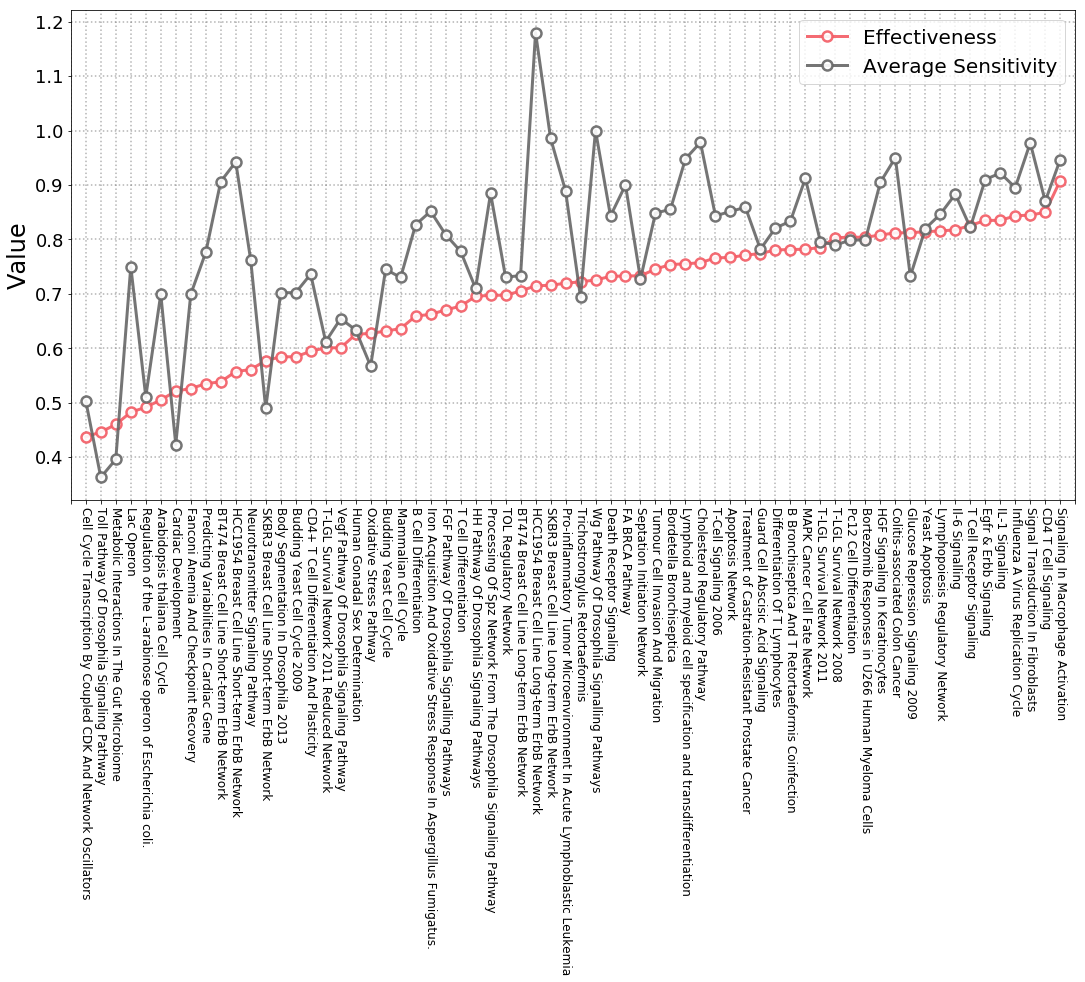

In [77]:
id_order = np.argsort(out_dict['eff'])
plt.figure(figsize=(18,9))

plt.plot(np.array(out_dict['eff'])[id_order],  marker='o', markersize=10, alpha=0.9,
         linestyle='-', linewidth=3.0,
         markeredgecolor='#f35b64', color='#f35b64', markeredgewidth=2.5, 
         markerfacecolor="w", label='Effectiveness')

plt.plot(np.array(out_dict['sensitivity'])[id_order],  marker='o', markersize=10, alpha=0.9,
         linestyle='-', linewidth=3.0,
         markeredgecolor='#666666', color='#666666', markeredgewidth=2.5, 
         markerfacecolor="w", label='Average Sensitivity')

xtix = np.linspace(-1,len(out_dict['NetworkID']),len(out_dict['NetworkID'])+2)
xticklist = [""]
for i in range(len(out_dict['NetworkID'])):
    xticklist.append(out_dict['NetworkID'][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=12)
# plt.yticks(np.linspace(0,2.5,11), ["%.2f"%i for i in np.linspace(0,2.5,11)], size=18)
plt.yticks(size=18)
plt.grid(alpha=0.6, color='grey', linestyle=':', linewidth=1.5)
plt.xlim(-1,len(out_dict['NetworkID']))
# plt.ylim(0.25,2.51)
plt.ylabel('Value', size=24)
plt.legend(fontsize=20)

# plt.savefig("figs/pngs/Walker_66networks_Sensitivity_vs_EI.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/Walker_66networks_Sensitivity_vs_EI.pdf", dpi=425, bbox_inches='tight')
plt.show()

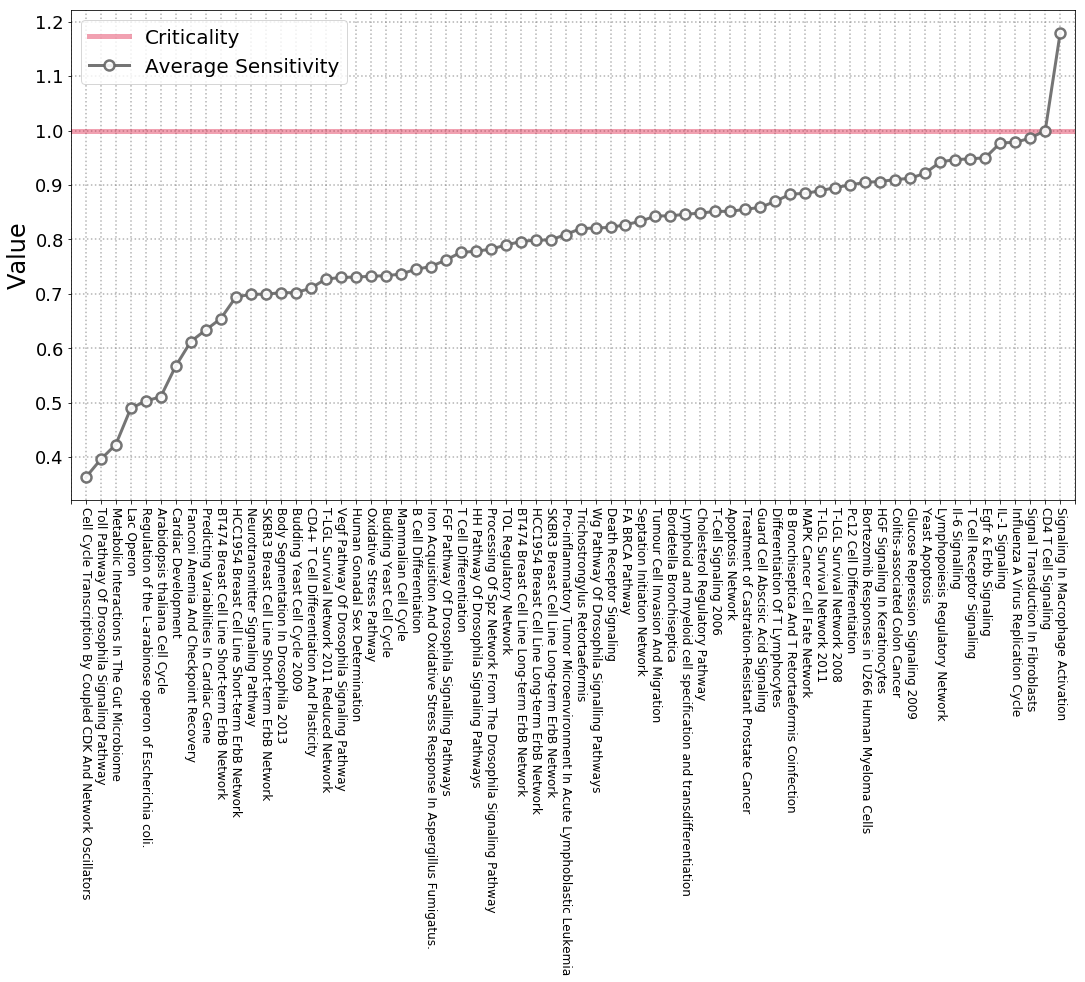

In [454]:
id_order = np.argsort(out_dict['sensitivity'])
plt.figure(figsize=(18,9))

# plt.plot(np.array(out_dict['eff'])[id_order],  marker='o', markersize=10, alpha=0.9,
#          linestyle='-', linewidth=3.0,
#          markeredgecolor='#f35b64', color='#f35b64', markeredgewidth=2.5, 
#          markerfacecolor="w", label='Effectiveness')

plt.plot([-4, 70], [1,1], marker='', alpha=0.4, linestyle='-', 
         linewidth=5.0, color='crimson', label='Criticality')
plt.plot(np.array(out_dict['sensitivity'])[id_order],  marker='o', markersize=10, alpha=0.9,
         linestyle='-', linewidth=3.0,
         markeredgecolor='#666666', color='#666666', markeredgewidth=2.5, 
         markerfacecolor="w", label='Average Sensitivity')

xtix = np.linspace(-1,len(out_dict['NetworkID']),len(out_dict['NetworkID'])+2)
xticklist = [""]
for i in range(len(out_dict['NetworkID'])):
    xticklist.append(out_dict['NetworkID'][i])
xticklist.append("")

plt.xticks(xtix, xticklist, rotation=270, size=12)
# plt.yticks(np.linspace(0,2.5,11), ["%.2f"%i for i in np.linspace(0,2.5,11)], size=18)
plt.yticks(size=18)
plt.grid(alpha=0.6, color='grey', linestyle=':', linewidth=1.5)
plt.xlim(-1,len(out_dict['NetworkID']))
# plt.ylim(0.25,2.51)
plt.ylabel('Value', size=24)
plt.legend(fontsize=20)

# plt.savefig("figs/pngs/Walker_66networks_Sensitivity.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/Walker_66networks_Sensitivity.pdf", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pngs/Walker_66networks_EI_vs_Sensitivity.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/Walker_66networks_EI_vs_Sensitivity.pdf", dpi=425, bbox_inches='tight')
plt.show()

In [ ]:
def scatter_plot_with_correlation_line(x, y, graph_filepath):
    # Scatter plot
    plt.scatter(x, y)

    # Add correlation line
    axes = plt.gca()
    m, b = np.polyfit(x, y, 1)
    X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
    plt.plot(X_plot, m*X_plot + b, '-')

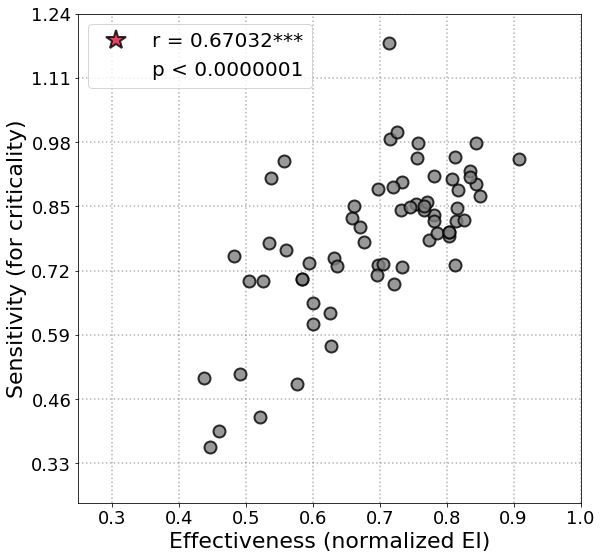

In [156]:
plt.figure(figsize=(9,9))

plt.plot(np.array(out_dict['eff']), np.array(out_dict['sensitivity']), marker='o', markersize=12, alpha=0.8,
         linestyle='', markeredgecolor='k', markeredgewidth=2.0,  markerfacecolor="grey")

xtix = np.linspace(-1,len(out_dict['NetworkID']),len(out_dict['NetworkID'])+2)
xticklist = [""]
for i in range(len(out_dict['NetworkID'])):
    xticklist.append(out_dict['NetworkID'][i])
xticklist.append("")

plt.xticks(np.linspace(0.2,1.0,9), np.round(np.linspace(0.2,1.0,9), 2), size=18)
plt.yticks(np.linspace(0.2,1.5,11), np.round(np.linspace(0.2,1.5,11), 2), size=18)
plt.grid(alpha=0.6, color='grey', linestyle=':', linewidth=1.5)
plt.ylabel('Sensitivity (for criticality)', size=22)
plt.xlabel('Effectiveness (normalized EI)', size=22)
plt.ylim(0.25, 1.24)
plt.xlim(0.25, 1.0)
x = np.array(out_dict['eff'])
y = np.array(out_dict['sensitivity'])
r, p = sp.stats.pearsonr(x, y)

plt.plot([100],[100],label='r = %.5f***'%r, markersize=20, alpha=0.8,
         marker='*',linestyle='',markeredgecolor='k', markeredgewidth=2.0,  markerfacecolor="crimson")
plt.plot([100],[100],label='p < %.6f1'%p, 
         marker='',linestyle='',markeredgecolor='k', markeredgewidth=2.0,  markerfacecolor="grey")

plt.legend(fontsize=20)

# plt.savefig("figs/pngs/Walker_66networks_Eff_corr_Sensitivity.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/Walker_66networks_Eff_corr_Sensitivity.pdf", dpi=425, bbox_inches='tight')
plt.show()

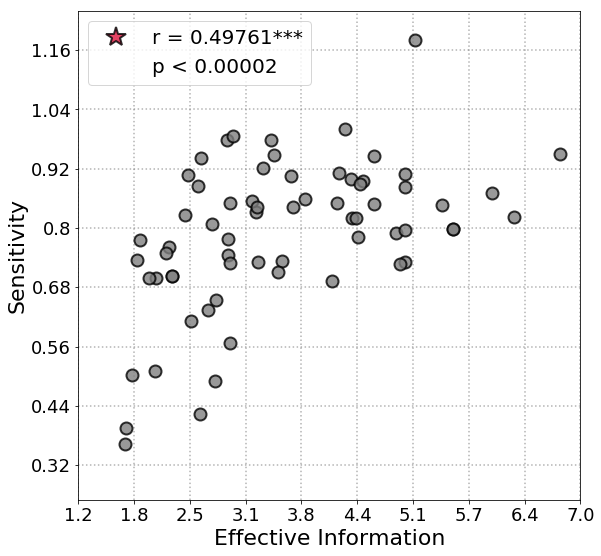

In [167]:
plt.figure(figsize=(9,9))

plt.plot(np.array(out_dict['EI']), np.array(out_dict['sensitivity']), marker='o', markersize=12, alpha=0.8,
         linestyle='', markeredgecolor='k', markeredgewidth=2.0,  markerfacecolor="grey")

xtix = np.linspace(-1,len(out_dict['NetworkID']),len(out_dict['NetworkID'])+2)
xticklist = [""]
for i in range(len(out_dict['NetworkID'])):
    xticklist.append(out_dict['NetworkID'][i])
xticklist.append("")

plt.xticks(np.linspace(1.2,7.0,10), np.round(np.linspace(1.2,7.0,10), 1), size=18)
plt.yticks(np.linspace(0.2,1.4,11), np.round(np.linspace(0.2,1.4,11), 2), size=18)
plt.grid(alpha=0.6, color='grey', linestyle=':', linewidth=1.5)
plt.ylabel('Sensitivity', size=22)
plt.xlabel('Effective Information', size=22)
plt.ylim(0.25, 1.24)
plt.xlim(1.20, 7.0)
x = np.array(out_dict['EI'])
y = np.array(out_dict['sensitivity'])
r, p = sp.stats.pearsonr(x, y)

plt.plot([100],[100],label='r = %.5f***'%r, markersize=20, alpha=0.8,
         marker='*',linestyle='',markeredgecolor='k', markeredgewidth=2.0,  markerfacecolor="crimson")
plt.plot([100],[100],label='p < %.5f'%p, 
         marker='',linestyle='',markeredgecolor='k', markeredgewidth=2.0,  markerfacecolor="grey")

plt.legend(fontsize=20)

# plt.savefig("figs/pngs/Walker_66networks_EI_corr_Sensitivity.png", dpi=425, bbox_inches='tight')
# plt.savefig("figs/pdfs/Walker_66networks_EI_corr_Sensitivity.pdf", dpi=425, bbox_inches='tight')
plt.show()

In [ ]:
# Apoptosis Network
tlg = nn.LogicNetwork.read_logic('data/walker/logic/expressions.ALL.txt', 
             external_nodes_path='data/walker/logic/external_components.ALL.txt')
tlG = nn.LogicNetwork.to_networkx_graph(tlg)
plt.figure(figsize=(8,8))
pos = nx.kamada_kawai_layout(tlG)
nx.draw_networkx(tlG, pos)
nx.draw_networkx_labels(tlG, pos)
plt.axis('off')
plt.show()

In [ ]:
xx = nn.LogicNetwork.to_networkx_graph(tlg, 'names')

In [ ]:
nn.examples.s_pombe.weights

In [ ]:
print("Adjacency:",ns.average_sensitivity(nn.WTNetwork(nx.to_numpy_array(tlG))))
W_out_test = get_Wout_full(tlG, p0=0)
net = nn.WTNetwork(W_out_test)
print("W_out:",ns.average_sensitivity(net, states=list(net.state_space())))
print("Boolean:",ns.average_sensitivity(tlg))

In [ ]:
y1 = []
y2 = []
for i in range(1000):
    if i%100==0:
        print(i)
    x1 = ns.average_sensitivity(net, states=list(tlg.state_space()), weights=np.random.uniform(-1,1,len(list(tlg.state_space()))))
    x2 = ns.average_sensitivity(tlg, states=list(tlg.state_space()), weights=np.random.uniform(-1,1,len(list(tlg.state_space()))))
    if abs(x1) < 3.0:
        y1.append(x1)
    if abs(x2) < 3.0:
        y2.append(x1)

In [ ]:
plt.figure(figsize=(16,9))
plt.hist(y1, bins=50, alpha=0.6)
plt.hist(y2, bins=50, alpha=0.6)

In [172]:
transistors_df = pd.read_csv("data/transistors.csv")
transistors_df.head()

bb   c1    c2  gate name     on       x       y  pos
0  [1450, 1510, 5143, 5320]  558   217   357   t0  False  1480.0  5231.5    0
1    [5424, 5629, 548, 922]  657   349  1608   t1  False  5526.5   735.0    1
2  [3867, 3899, 2465, 2642]  558  1146   412   t2  False  3883.0  2553.5    2
3  [7907, 7990, 9237, 9311]  558   943   558   t3  False  7948.5  9274.0    3
4    [1893, 1910, 530, 927]  230   657   826   t4  False  1901.5   728.5    4

In [254]:
c1c2np = np.array(transistors_df[['c1','c2']])
c1c2el = [tuple(c1c2np[i]) for i in range(len(c1c2np))]

gac1np = np.array(transistors_df[['gate','c1']])
gac1el = [tuple(gac1np[i]) for i in range(len(gac1np))]

gac2np = np.array(transistors_df[['gate','c2']])
gac2el = [tuple(gac2np[i]) for i in range(len(gac2np))]

c1c2 = nx.from_edgelist(c1c2el)
gac1 = nx.from_edgelist(gac1el)
gac2 = nx.from_edgelist(gac2el)

In [255]:
pos = np.array(transistors_df[['x','y']])
col = np.array(transistors_df[['name']])
col_mapping = dict(zip(np.unique(col), list(range(len(np.unique(col))))))
ncol = {col_mapping[i]:col_mapping[i]/max(col_mapping.values()) for i in list(transistors_df['name'])}
# nc = plt.cm.rainbow(np.array(list(ncol.values())))
# pos = nx.kamada_kawai_layout(c1c2)

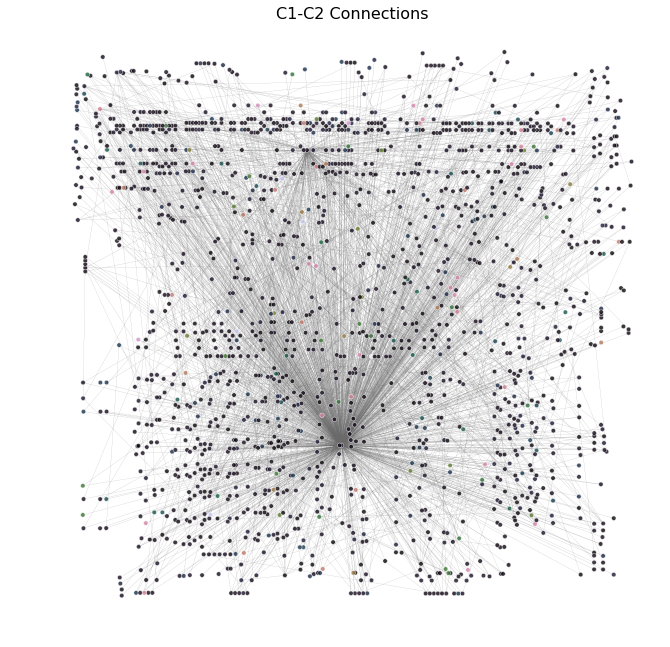

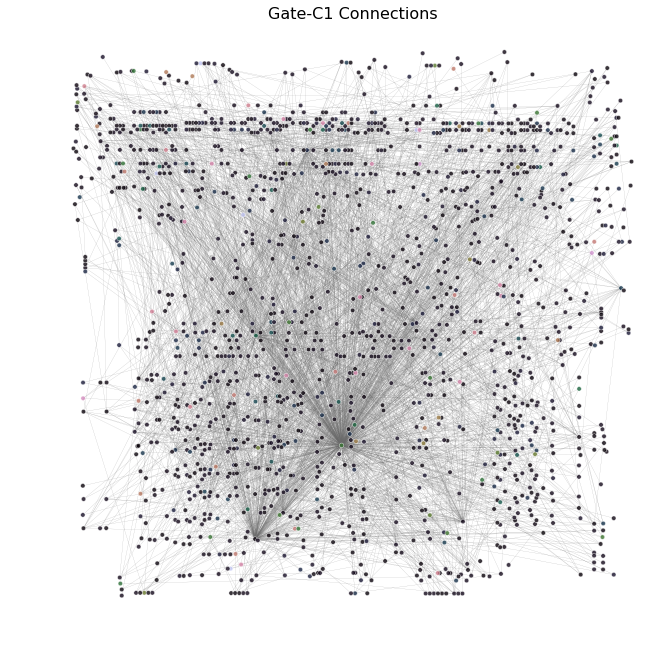

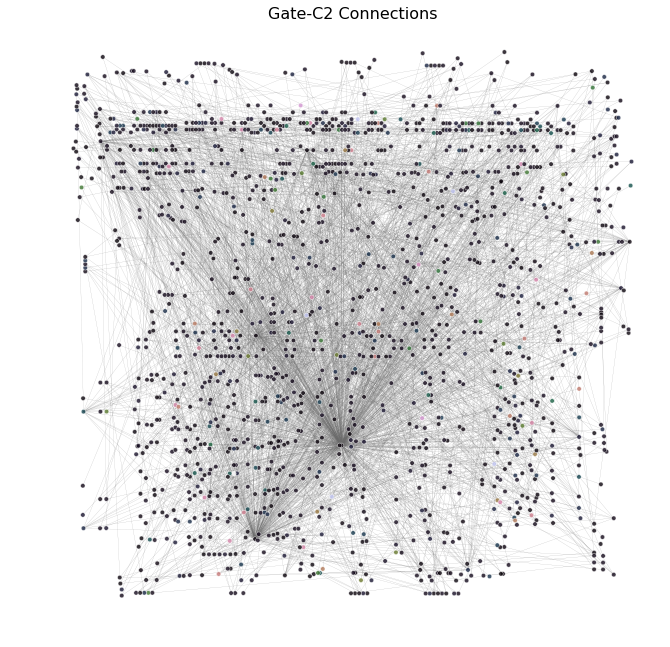

In [300]:
plt.figure(figsize=(11,11))
nx.draw_networkx_nodes(c1c2, pos, node_color=nc, node_size=20, edgecolors='w', linewidths=0.5, alpha=0.8)
nx.draw_networkx_edges(c1c2, pos, edge_color='#666666', width=0.10)
plt.title("C1-C2 Connections", size=16)
plt.axis('off')
plt.show()

plt.figure(figsize=(11,11))
nx.draw_networkx_nodes(gac1, pos, node_color=nc, node_size=20, edgecolors='w', linewidths=0.5, alpha=0.8)
nx.draw_networkx_edges(gac1, pos, edge_color='#666666', width=0.10)
plt.title("Gate-C1 Connections", size=16)
plt.axis('off')
plt.show()

plt.figure(figsize=(11,11))
nx.draw_networkx_nodes(gac2, pos, node_color=nc, node_size=20, edgecolors='w', linewidths=0.5, alpha=0.8)
nx.draw_networkx_edges(gac2, pos, edge_color='#666666', width=0.10)
plt.title("Gate-C2 Connections", size=16)
plt.axis('off')
plt.show()

In [258]:
transistors_df = pd.read_csv("data/transistors.csv")
transistors_df.head()

bb   c1    c2  gate name     on       x       y  pos
0  [1450, 1510, 5143, 5320]  558   217   357   t0  False  1480.0  5231.5    0
1    [5424, 5629, 548, 922]  657   349  1608   t1  False  5526.5   735.0    1
2  [3867, 3899, 2465, 2642]  558  1146   412   t2  False  3883.0  2553.5    2
3  [7907, 7990, 9237, 9311]  558   943   558   t3  False  7948.5  9274.0    3
4    [1893, 1910, 530, 927]  230   657   826   t4  False  1901.5   728.5    4

In [385]:
ws = []
for i in range(len(transistors_df)):
    bb = transistors_df['bb'][i]
    bb = ast.literal_eval(bb)
    widths = bb[1]-bb[0]
    height = bb[3]-bb[2]
    ws.append(widths*height)

In [440]:
col = [(ws[i]+20000)/(max(ws)*1.2) for i in range(len(ws))]
# col = [(ws[i]+80000)/(max(ws)*1.6) for i in range(len(ws))]
nc = plt.cm.gist_ncar(np.array(col))

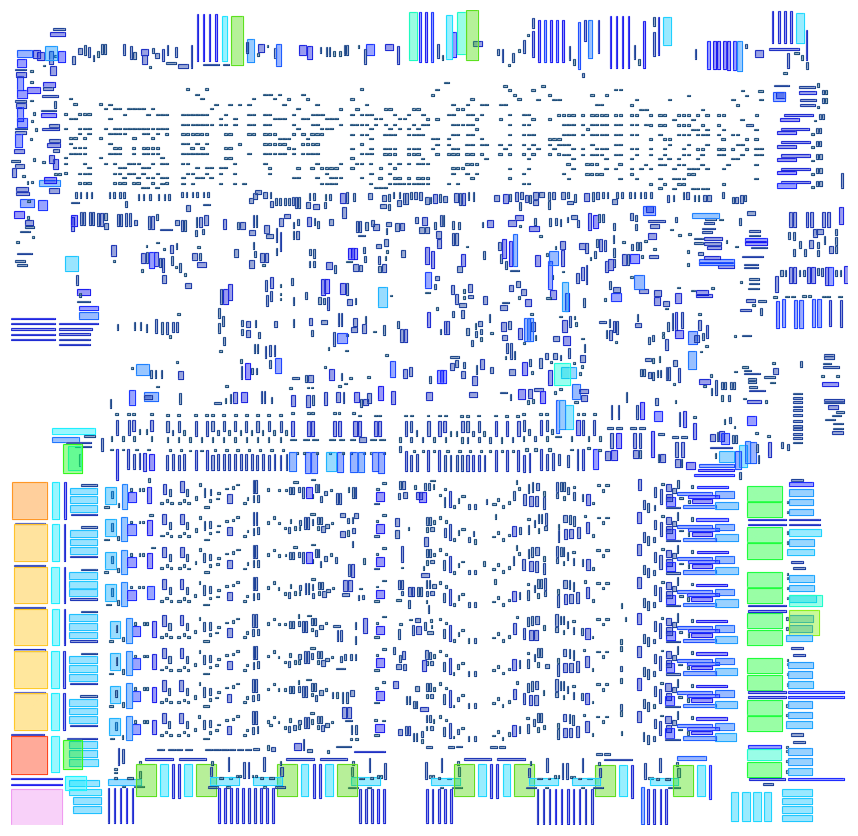

In [450]:
fig, ax = plt.subplots(1, figsize=(15,15))

# Create a Rectangle patch
xmin_bb = 4000
xmax_bb = 4000
ymin_bb = 4000
ymax_bb = 4000
for i in range(len(transistors_df)):
    bb = transistors_df['bb'][i]
    bb = ast.literal_eval(bb)
    if bb[1] > xmax_bb:
        xmax_bb = bb[1]
    if bb[0] < xmin_bb:
        xmin_bb = bb[0]
    if bb[3] > ymax_bb:
        ymax_bb = bb[3]
    if bb[2] < ymin_bb:
        ymin_bb = bb[2]
    rect = patches.Rectangle((bb[0],bb[2]),bb[1]-bb[0],bb[3]-bb[2], 
                             linewidth=1.15, edgecolor=nc[i],facecolor='none')
    ax.add_patch(rect)

    rect = patches.Rectangle((bb[0],bb[2]),bb[1]-bb[0],bb[3]-bb[2], 
                             linewidth=0, edgecolor='none',facecolor=nc[i], alpha=0.6)
    ax.add_patch(rect)
    
    rect = patches.Rectangle((bb[0],bb[2]),bb[1]-bb[0],bb[3]-bb[2], 
                             linewidth=0.25, edgecolor='w',facecolor='none')
    ax.add_patch(rect)

nx.draw_networkx_edges(c1c2, pos, edge_color='w', width=0.10, alpha=0.6)
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
plt.xlim(xmin_bb-1,xmax_bb+1)
plt.ylim(ymin_bb-1,ymax_bb+1)
plt.axis('off')

# plt.savefig("figs/pngs/MicroProcessor0.png", dpi=425, bbox_inches='tight', facecolor='#262626')
# plt.savefig("figs/pdfs/MicroProcessor0.pdf", dpi=425, bbox_inches='tight', facecolor='#262626')
plt.savefig("figs/pngs/MicroProcessor1.png", dpi=425, bbox_inches='tight', facecolor='#262626')
plt.savefig("figs/pdfs/MicroProcessor1.pdf", dpi=425, bbox_inches='tight', facecolor='#262626')

plt.show()

In [ ]:
G = nx.read_gml('data/9.gml')
print("degen:", np.round(get_degeneracy(G)/np.log2(G.number_of_nodes()), 5), 
      "\ndeter:", np.round(get_determinism(G)/np.log2(G.number_of_nodes()), 5), 
      "\neffin:", np.round(get_ei(G)/np.log2(G.number_of_nodes()), 5))
print("degen:", np.round(get_degeneracy(G), 5), 
      "\ndeter:", np.round(get_determinism(G), 5), 
      "\neffin:", np.round(get_ei(G), 5))

plt.figure(figsize=(10,10))
nx.draw_kamada_kawai(G, node_color='dodgerblue', node_size=150, edge_width=2.0, edge_color='grey')
plt.show()

G = nx.convert_node_labels_to_integers(G)

partition = community.best_partition(nx.to_undirected(G))
comms = np.array([partition[i] for i in G.nodes()])
node_colors_co = [colors[i] for i in comms]
dorm_lists = assignmentArray_to_lists(partition)
nodes_dorm_ordered = [node for dorm in dorm_lists for node in dorm]

draw_adjacency_matrix(G, nodes_dorm_ordered, [dorm_lists], ["dodgerblue"])